In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('a.csv', parse_dates=['Date'], index_col='Date')

# Display the first few rows of the dataframe
print(df.head())


            price
Date             
2016-01-02    120
2016-01-03    100
2016-01-04     50
2016-01-06    150
2016-01-07    140


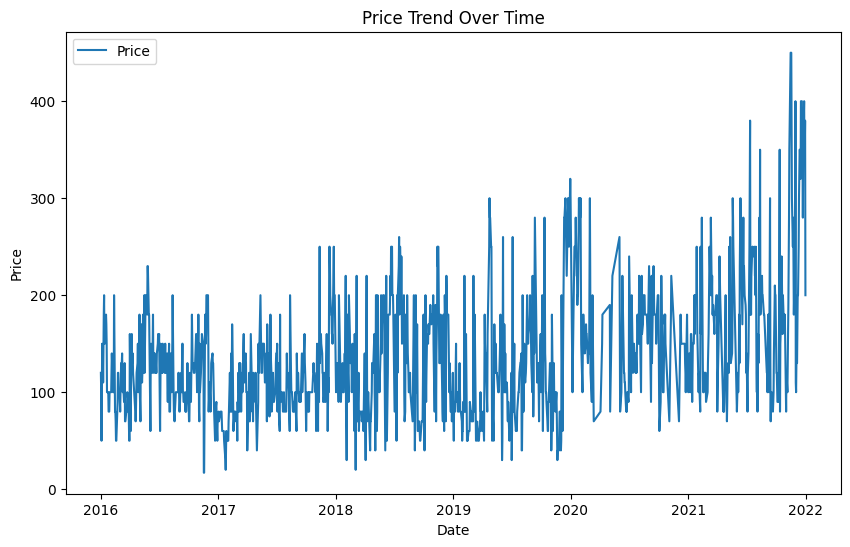

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(df['price'], label='Price')
plt.title('Price Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [40]:
from sklearn.preprocessing import MinMaxScaler

# Scaling the price data to the range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
df['price'] = scaler.fit_transform(df[['price']])

# Create training and testing datasets
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]


In [41]:
def create_dataset(data, look_back=1):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

# Using the last 60 days to predict the next day's price
look_back = 60
X_train, y_train = create_dataset(train.values, look_back)
X_test, y_test = create_dataset(test.values, look_back)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


c:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [43]:
# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 0.0324 - val_loss: 0.0365
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0142 - val_loss: 0.0441
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0128 - val_loss: 0.0401
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0128 - val_loss: 0.0348
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0121 - val_loss: 0.0363
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0109 - val_loss: 0.0308
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0116 - val_loss: 0.0334
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0127 - val_loss: 0.0314
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0109 - val_loss: 0.0308
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0109 - val_loss: 0.0327
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0103 - val_loss: 0.0304
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0

In [44]:
# Predict using the trained model
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Invert predictions and actual values from scaled form back to original prices
train_predictions = scaler.inverse_transform(train_predictions)
y_train_actual = scaler.inverse_transform([y_train])
test_predictions = scaler.inverse_transform(test_predictions)
y_test_actual = scaler.inverse_transform([y_test])



31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [45]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_squared_log_error


y_test_actual_flat = y_test_actual.flatten()
test_predictions_flat = test_predictions.flatten()

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test_actual_flat, test_predictions_flat)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calculate Root Mean Squared Logarithmic Error (RMSLE)
y_test_actual_flat_safe = np.maximum(y_test_actual_flat, 1e-10)
test_predictions_flat_safe = np.maximum(test_predictions_flat, 1e-10)

rmsle = np.sqrt(mean_squared_log_error(y_test_actual_flat_safe, test_predictions_flat_safe))
print(f'Root Mean Squared Logarithmic Error (RMSLE): {rmsle}')
percentage_errors = np.abs((y_test_actual_flat - test_predictions_flat) / y_test_actual_flat) * 100

# Calculate mean percentage error
mean_percentage_error = np.mean(percentage_errors)
print(f'Mean Percentage Error (MPE): {mean_percentage_error:.2f}%')


Mean Squared Error (MSE): 4685.969802932173
Root Mean Squared Error (RMSE): 68.45414379664808
Root Mean Squared Logarithmic Error (RMSLE): 0.360590988340368
Mean Percentage Error (MPE): 28.46%


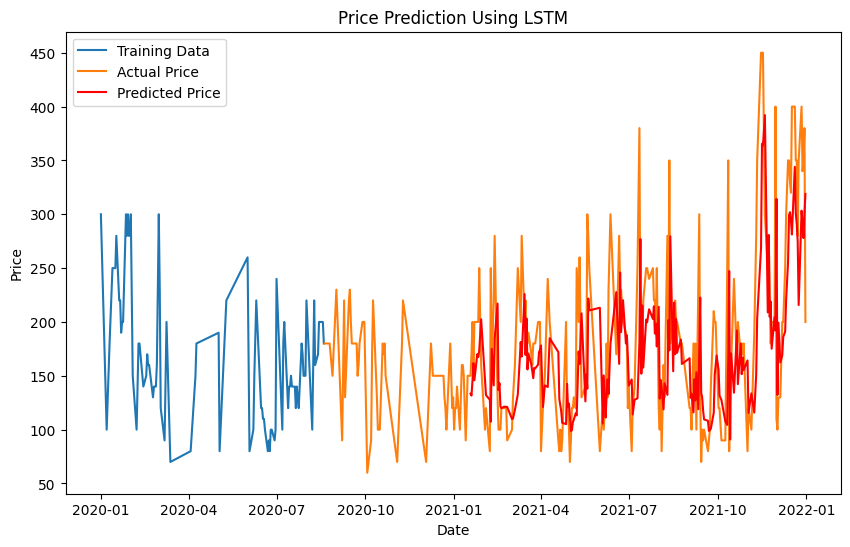

In [46]:
# Plot the actual vs predicted value
# plt.figure(figsize=(10, 6))
plt.figure(figsize=(10, 6))
filtered_index_train = df.index[:train_size][df.index[:train_size] >= '2020-01-01']
filtered_index_test = df.index[train_size:][df.index[train_size:] >= '2020-01-01']
filtered_index_predictions = df.index[train_size+look_back:][df.index[train_size+look_back:] >= '2020-01-01']

plt.plot(filtered_index_train, scaler.inverse_transform(train.values[df.index[:train_size] >= '2020-01-01']), label='Training Data')
plt.plot(filtered_index_test, scaler.inverse_transform(test.values[df.index[train_size:] >= '2020-01-01']), label='Actual Price')
plt.plot(filtered_index_predictions, test_predictions[df.index[train_size+look_back:] >= '2020-01-01'], label='Predicted Price', color='red')


# plt.plot(df.index[:train_size], scaler.inverse_transform(train.values), label='Training Data')
# plt.plot(df.index[train_size:], scaler.inverse_transform(test.values), label='Actual Price')
# plt.plot(df.index[train_size+look_back:], test_predictions, label='Predicted Price', color='red')
plt.title('Price Prediction Using LSTM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

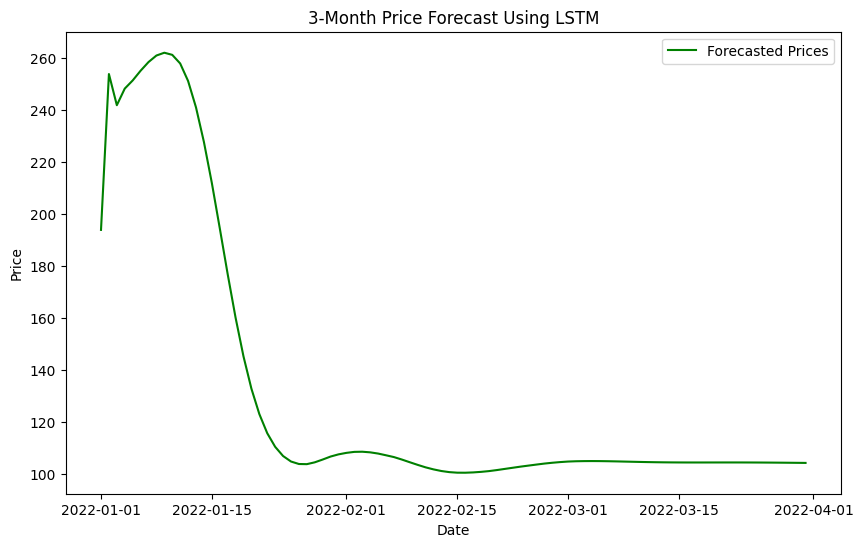

In [47]:
# Use the last part of the test set for prediction
last_sequence = df[-look_back:].values
forecast_input = last_sequence
forecast = []

# Forecast the next 90 days (approx. 3 months)
for _ in range(90):
    forecast_input_reshaped = np.reshape(forecast_input, (1, look_back, 1))
    next_price = model.predict(forecast_input_reshaped)
    forecast.append(next_price[0, 0])
    forecast_input = np.append(forecast_input[1:], next_price[0, 0])

# Invert the forecasted values to the original price scale
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# Generate future dates for the next 90 days
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=90, freq='D')

# Plot forecasted prices
plt.figure(figsize=(10, 6))
plt.plot(future_dates, forecast, label='Forecasted Prices', color='green')
plt.title('3-Month Price Forecast Using LSTM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
